# Exercícios Intermediários - KNN

---

##  Exercício Intermediário 1

### Importação do dataset

Resolvi pegar um dataset de facil acesso no sklearn com duas classes. Transformei ele em bidimensional para facilitar na visualização e aplicação do algoritimo com as funções que ja tinha feito.

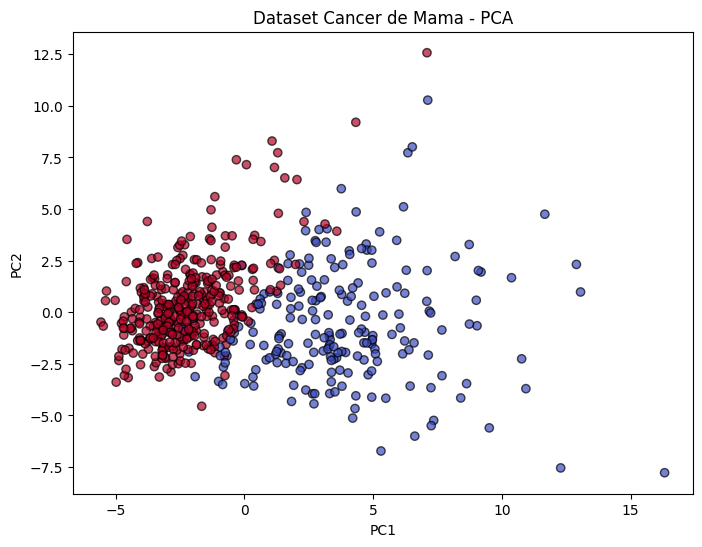

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer

# Carregando dataset de câncer de mama
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Padronizando e reduzindo dimensões
X = StandardScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X)

# Convertendo labels para -1 e 1
y = np.where(y == 0, -1, 1)

# Visualizando dados após PCA
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset Cancer de Mama - PCA')
plt.show()

### Criação da função KNN

In [3]:
def knn(X, Y, xt, k):
    # calculando distancia entre xt e todos os outros pontos
    dist = (((X.T-xt).T)**2).sum(axis=1)
    # predição usando o sinal da soma dos k vizinhos mais próximos
    pred = np.sign(Y[dist.argsort()[:k]].sum())
    return pred

Repetições: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


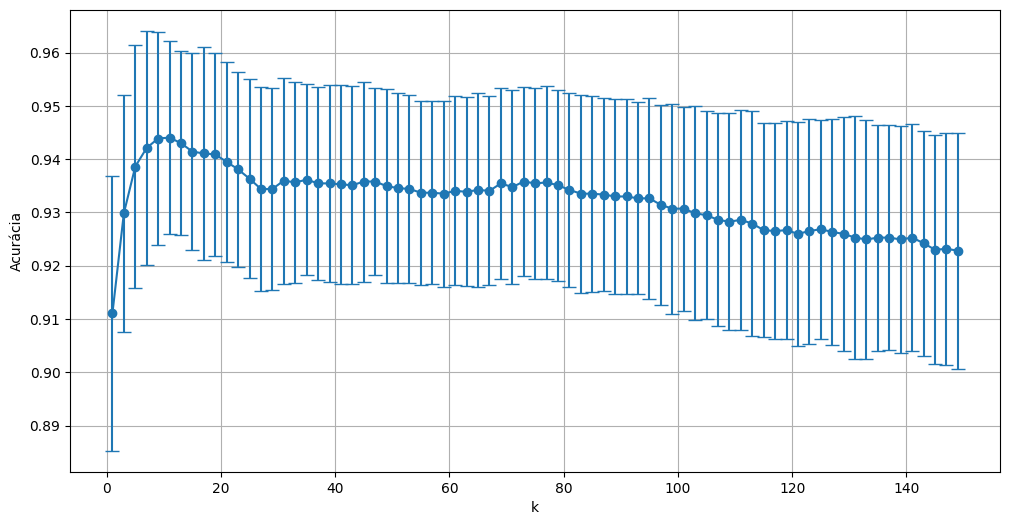

In [8]:
from tqdm import tqdm

resultados = {k: [] for k in range(1, 150, 2)}

for repeticao in tqdm(range(50), desc="Repetições"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=repeticao)
    
    for k in range(1, 150, 2):
        test_preds = []
        for xt in X_test:
            pred = knn(X_train, y_train, xt.reshape(xt.shape[0],1), k=int(k))
            test_preds.append(pred)
        test_preds = np.array(test_preds)
        resultados[k].append((y_test==test_preds).mean())

acuracy_mean = {k: np.mean(vals) for k, vals in resultados.items()}
acuracy_std = {k: np.std(vals) for k, vals in resultados.items()}

plt.figure(figsize=(12, 6))
plt.errorbar(list(acuracy_mean.keys()), list(acuracy_mean.values()), 
            yerr=list(acuracy_std.values()), fmt='o-', capsize=5)
plt.xlabel('k')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

Este gráfico mostra a média das acurácias para cada valor de k, obtida após repetir o processo de divisão do dataset em treino e teste 50 vezes. Ficou evidente que há um pico de acurácia próximo a k = 11. Além disso, observamos um desvio padrão em torno de 3% para todos os valores de k, indicando uma variação relativamente estável entre as execuções. Esse método forneceu uma boa estimativa para o valor ótimo de k, mas apresentou um custo computacional elevado. Inicialmente, testei o experimento em um dataset significativamente maior, mas apenas uma repetição do processo de divisão e teste levou 40 minutos, tornando inviável sua aplicação em larga escala. Por esse motivo, optei por um dataset menor para viabilizar a execução. Essa abordagem, embora eficaz, não se escala bem para conjuntos de dados muito grandes.

---

##  Exercício Intermediário 2

In [9]:
def pdfnvar(x, m, K, n=2):
    x = np.asarray(x).reshape(-1)  # Garante que x é um vetor 1D
    m = np.asarray(m).reshape(-1)  # Garante que m é um vetor 1D
    diff = x - m
    exponent = -0.5 * np.dot(diff.T, np.linalg.solve(K, diff))  # Usa np.linalg.solve para evitar problemas
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(K))
    return (1 / denominator) * np.exp(exponent)


In [11]:
def knn_dist_vect(X, Y, xt, k , h=0.5):
    dist = (((X.T-xt).T)**2).sum(axis=1)
    n = X.shape[1]
    K = h*np.eye(n)
    sum_neg = 0
    sum_pos = 0
    for datapoint,label in zip(X[dist.argsort()[:k]],Y[dist.argsort()[:k]]):
        if label ==1:
            sum_pos += label * pdfnvar(datapoint, xt, K, n)
        else:
            sum_neg += label * pdfnvar(datapoint, xt, K, n)
    pred = np.sign((sum_pos+sum_neg))
    pred_vec = np.array([sum_pos,-1*sum_neg])
    return pred, pred_vec

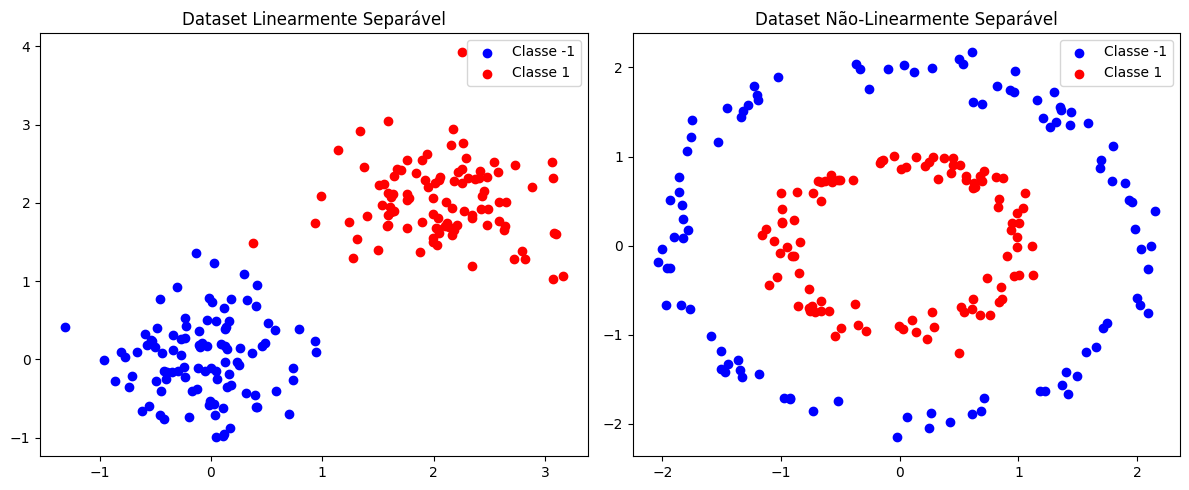

In [ ]:
import numpy as np

# Dataset linearmente separável
np.random.seed(42)
n_pontos = 200

X_linear = np.vstack([
    np.random.normal(0, 0.5, (n_pontos//2, 2)),  # classe -1
    np.random.normal(2, 0.5, (n_pontos//2, 2))   # classe 1
])
y_linear = np.array([-1]*(n_pontos//2) + [1]*(n_pontos//2))

# Dataset não-linearmente separável (círculos)
theta = np.random.uniform(0, 2*np.pi, n_pontos//2)
r_interno = np.random.normal(1, 0.1, n_pontos//2)
r_externo = np.random.normal(2, 0.1, n_pontos//2)

X_nao_linear = np.vstack([
    np.column_stack([r_externo*np.cos(theta), r_externo*np.sin(theta)]),  # classe -1
    np.column_stack([r_interno*np.cos(theta), r_interno*np.sin(theta)])   # classe 1
])
y_nao_linear = np.array([-1]*(n_pontos//2) + [1]*(n_pontos//2))

# Visualização
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X_linear[y_linear==-1,0], X_linear[y_linear==-1,1], c='blue', label='Classe -1')
plt.scatter(X_linear[y_linear==1,0], X_linear[y_linear==1,1], c='red', label='Classe 1')
plt.title('Dataset Linearmente Separável')
plt.legend()

plt.subplot(122)
plt.scatter(X_nao_linear[y_nao_linear==-1,0], X_nao_linear[y_nao_linear==-1,1], c='blue', label='Classe -1')
plt.scatter(X_nao_linear[y_nao_linear==1,0], X_nao_linear[y_nao_linear==1,1], c='red', label='Classe 1')
plt.title('Dataset Não-Linearmente Separável')
plt.legend()

plt.tight_layout()
plt.show()

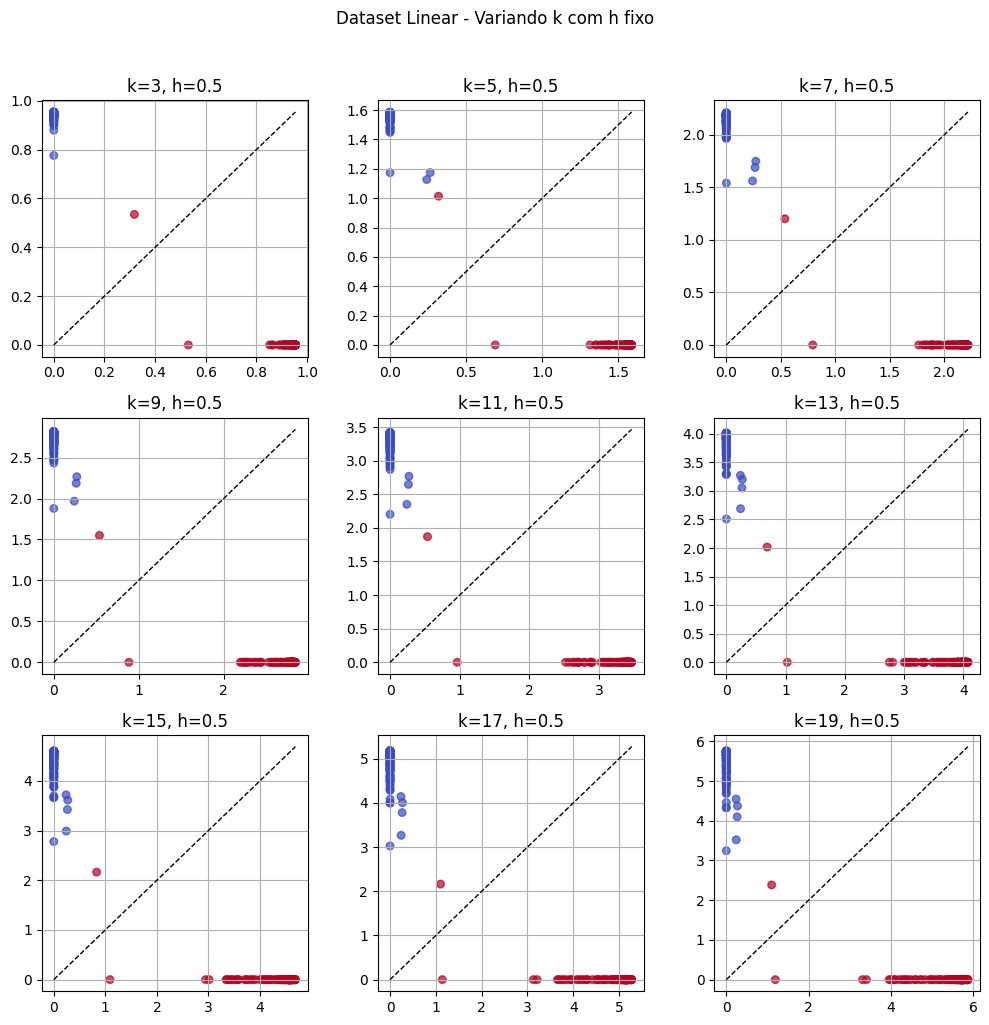

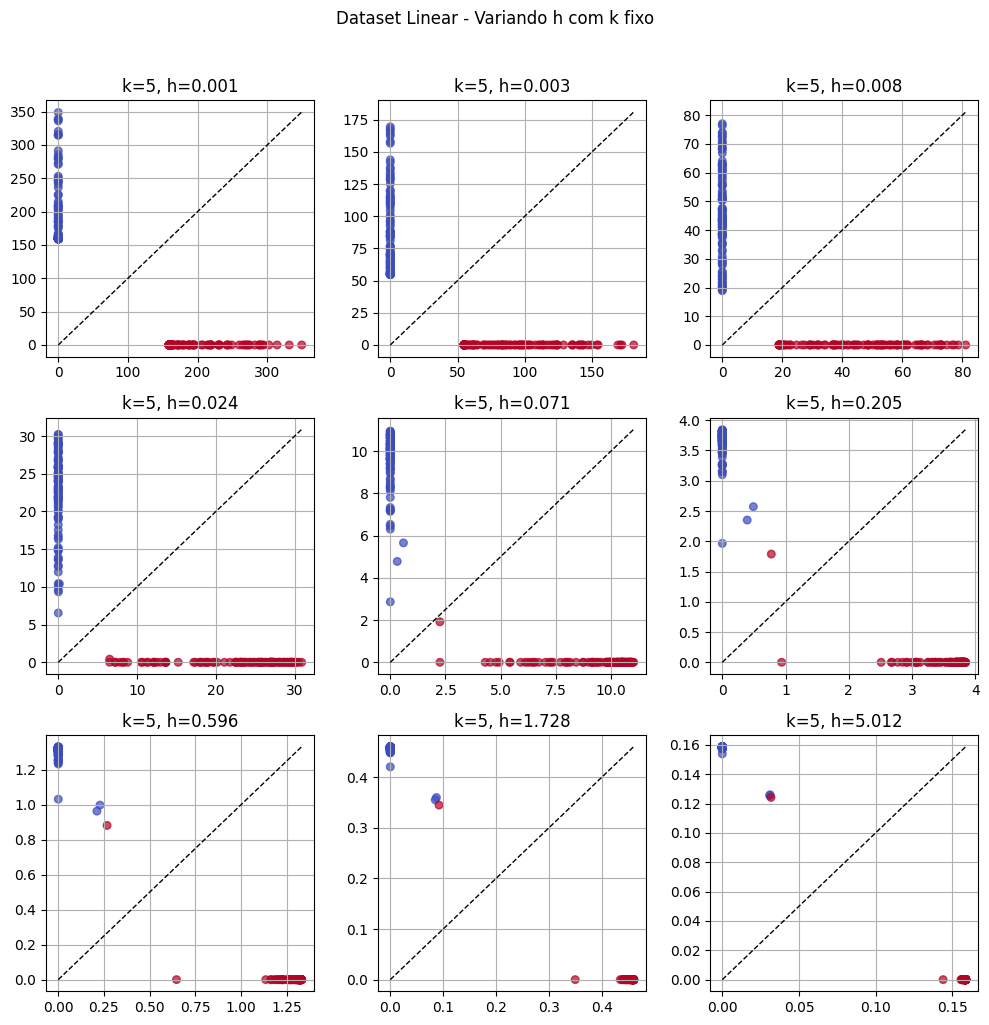

In [17]:
# Definindo os ranges para k e h
ks = np.arange(3, 20, 2)  # Range linear para k
hs = np.logspace(-3, 0.7, num=9)  # Range logarítmico para h

# Variando k com h fixo
plt.figure(figsize=(10, 10))
h_fixo = 0.5
for i, k in enumerate(ks, 1):
    vectors = []
    for xt in X_linear:
        _, pred_vec = knn_dist_vect(X_linear, y_linear, xt.reshape(2, 1), k, h=h_fixo)
        vectors.append(pred_vec)
    vectors = np.array(vectors)
    
    plt.subplot(3, 3, i)
    plt.scatter(vectors[:, 0], vectors[:, 1], c=y_linear, cmap='coolwarm', alpha=0.7, s=30)
    x_vals = np.linspace(min(vectors[:, 0]), max(vectors[:, 0]), 100)
    plt.plot(x_vals, x_vals, linestyle="--", color="black", linewidth=1)
    plt.title(f"k={k}, h={h_fixo}")
    plt.grid(True)
plt.suptitle("Dataset Linear - Variando k com h fixo", y=1.02)
plt.tight_layout()
plt.show()

# Variando h com k fixo
plt.figure(figsize=(10, 10))
k_fixo = 5
for i, h in enumerate(hs, 1):
    vectors = []
    for xt in X_linear:
        _, pred_vec = knn_dist_vect(X_linear, y_linear, xt.reshape(2, 1), k_fixo, h=h)
        vectors.append(pred_vec)
    vectors = np.array(vectors)
    
    plt.subplot(3, 3, i)
    plt.scatter(vectors[:, 0], vectors[:, 1], c=y_linear, cmap='coolwarm', alpha=0.7, s=30)
    x_vals = np.linspace(min(vectors[:, 0]), max(vectors[:, 0]), 100)
    plt.plot(x_vals, x_vals, linestyle="--", color="black", linewidth=1)
    plt.title(f"k={k_fixo}, h={h:.3f}")
    plt.grid(True)
plt.suptitle("Dataset Linear - Variando h com k fixo", y=1.02)
plt.tight_layout()
plt.show()

---